By: 顾 瞻 GU Zhan (Sam)

Sep 2017

### SHL github project: uat_shl

* training module: shl_tm

* prediction module: shl_pm

* simulation module: shl_sm

* misc module: shl_mm


### data feeds:

* historical bidding price, per second, time series

* live bidding price, per second, time series

### parameter lookup table: python dictionary



In [1]:
import pandas as pd

### Read raw data

In [3]:
df_history_ts_process = pd.read_csv('data/history_ts.csv') 
df_history_ts_process.tail()

,ccyy-mm,time,bid-price,ref-price
1886,2017-07,11:29:56,92100,89800
1887,2017-07,11:29:57,92100,89800
1888,2017-07,11:29:58,92100,89800
1889,2017-07,11:29:59,92200,89800
1890,2017-07,11:30:00,92200,89800


In [4]:
df_history_table_process = pd.read_csv('data/history_table.csv') 
df_history_table_process.tail()

,ccyy-mm,volume-plate,deal-price-low,deal-price-avg,deal-early-second,volume-bidder
26,2017-03,10356,87800,87916,55,262010
27,2017-04,12196,89800,89850,59,252273
28,2017-05,10316,90100,90209,55,270197
29,2017-06,10312,89400,89532,45,244349
30,2017-07,10325,92200,92250,57,269189


In [7]:
df_parm_si = pd.read_csv('data/parm_si.csv') 
print(df_parm_si[(df_parm_si['ccyy-mm'] == '2017-08') & (df_parm_si['time'] == '11:29:00')].iloc[0]['SI'])
df_parm_si.tail()

0.002373838


,ccyy-mm,time,SI
2191,2017-12,11:29:56,1.0
2192,2017-12,11:29:57,1.0
2193,2017-12,11:29:58,1.0
2194,2017-12,11:29:59,1.0
2195,2017-12,11:30:00,1.0


In [80]:
df_parm_month = pd.read_csv('data/parm_month.csv') 
print(df_parm_month[(df_parm_month['ccyy-mm'] == '2017-07') & (df_parm_month['time'] == '11:29:00')].iloc[0]['di'])
df_parm_month.tail()

300


,ccyy-mm,time,alpha,beta,gamma,sec57-weight,month-weight,short-weight,direction,di
67,2020-08,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
68,2020-09,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
69,2020-10,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
70,2020-11,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
71,2020-12,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300


# Initialization

In [81]:
# function to fetch Seasonality-Index
def fetech_si(ccyy_mm, time, df_parm_si):
#     return df_parm_si[(df_parm_si['ccyy-mm'] == '2017-09') & (df_parm_si['time'] == '11:29:00')]
    return df_parm_si[(df_parm_si['ccyy-mm'] == ccyy_mm) & (df_parm_si['time'] == time)].iloc[0]['SI']


In [82]:
# function to fetch Dynamic-Increment
def fetech_di(ccyy_mm, df_parm_month):
#     print(df_parm_month[df_parm_month['ccyy-mm'] == '2017-07'].iloc[0]['di'])
    return df_parm_month[df_parm_month['ccyy-mm'] == ccyy_mm].iloc[0]['di']


In [83]:
def get_previous_n_sec_time_as_str(df_time_field, n):
    return str((pd.to_datetime(df_time_field, format='%H:%M:%S') - pd.Timedelta(seconds=n)).time())


In [84]:
#
global_parm_ccyy_mm = '2017-07' # which month to predict?

# create global base price
global_parm_base_price = 10000000

# default set to +200
global_parm_dynamic_increment = 200

# create predictino results dataframe: shl_pm
# df_shl_pm = pd.DataFrame()

global_parm_dynamic_increment = fetech_di(df_history_ts_process['ccyy-mm'][i], df_parm_month)

global_parm_alpha = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['alpha']
global_parm_beta  = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['beta']
global_parm_gamma = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['gamma']



print('global_parm_alpha       : %0.10f' % global_parm_alpha)
print('global_parm_beta        : %0.10f' % global_parm_beta)
print('global_parm_gamma       : %0.10f' % global_parm_gamma)


global_parm_alpha       : 0.6423321348
global_parm_beta        : 0.2302748926
global_parm_gamma       : 0.2180442895


# Start of shl_sm

In [98]:


for i in range(1830, len(df_history_ts_process)): # use July 2015 data as simulatino
    print('\n<<<< Record No.: %5d >>>>' % i)
    print(df_history_ts_process['ccyy-mm'][i]) # format: ccyy-mm
    print(df_history_ts_process['time'][i]) # format: hh:mm:ss
    print(df_history_ts_process['bid-price'][i]) # format: integer
#     print(df_history_ts_process['ref-price'][i])
    
    # capture & calculate 11:29:00 bid price - 1 = base price
    if df_history_ts_process['time'][i] == '11:29:00':
        global_parm_base_price = df_history_ts_process['bid-price'][i] -1 
        print('#### global_parm_base_price : %d ####' % global_parm_base_price)

        
    print('---- Pre-Process ---')
    # pre-process: ccyy-mm-hh:mm:ss
    current_datetime = df_history_ts_process['ccyy-mm'][i] + ' ' + df_history_ts_process['time'][i]
    current_price4pm = df_history_ts_process['bid-price'][i] -  global_parm_base_price
    print('#### current_datetime   : %s ####' %  current_datetime)
    print('#### current_price4pm   : %d ####' % current_price4pm)
    
    # get Seasonality-Index
    current_si = fetech_si(df_history_ts_process['ccyy-mm'][i]
                                         ,df_history_ts_process['time'][i]
                                         ,df_parm_si)
    print('#### current_si         : %0.10f ####' %  current_si)
    # get de-seasoned price: price4pmsi
    current_price4pmsi = current_price4pm / current_si
    print('#### current_price4pmsi : %0.10f ####' % current_price4pmsi)
    


    if df_history_ts_process['time'][i] == '11:29:00':
        df_shl_pm = pd.DataFrame() # initialize prediction dataframe at 11:29:00
        print('---- call predicitno function shl_pm ---- %s' % df_history_ts_process['time'][i])
        current_pred_les_level = current_price4pmsi
        current_pred_les_trend = 0
        current_pred_les = current_pred_les_level + current_pred_les_trend
        current_pred_les_misc = 0
        current_pred_price = (current_pred_les + current_pred_les_misc) * current_si \
                                + global_parm_base_price
        current_pred_price_rounded = round(current_pred_price/100, 0) * 100
        current_pred_dynamic_increment = global_parm_dynamic_increment
        current_pred_set_price_rounded = current_pred_price_rounded + current_pred_dynamic_increment
    else:
#         call predicitno functino shl_pm
        print('---- call predicitno function shl_pm ---- %s' % df_history_ts_process['time'][i])
        previous_time = get_previous_n_sec_time_as_str(df_history_ts_process['time'][i], 1)
        previous_pred_les_level = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['pred_les_level']
        print('     previous_pred_les_level ',  previous_pred_les_level)
        
        previous_pred_les_trend = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['pred_les_trend']
        print('     previous_pred_les_trend ',  previous_pred_les_trend)
        
        current_pred_les_level = global_parm_alpha * current_price4pmsi \
                                    + (1 - global_parm_alpha) * (previous_pred_les_level + previous_pred_les_trend)
        print('     current_pred_les_level ',  current_pred_les_level)
        current_pred_les_trend = global_parm_beta * (current_pred_les_level - previous_pred_les_level) \
                                    + (1 - global_parm_beta) * previous_pred_les_trend
        print('     current_pred_les_trend ',  current_pred_les_trend)
        current_pred_les = current_pred_les_level + current_pred_les_trend
        current_pred_les_misc = 0
        current_pred_price = (current_pred_les + current_pred_les_misc) * current_si \
                                + global_parm_base_price
        current_pred_price_rounded = round(current_pred_price/100, 0) * 100
        current_pred_dynamic_increment = global_parm_dynamic_increment
        current_pred_set_price_rounded = current_pred_price_rounded + current_pred_dynamic_increment
   
        
    # write results to shl_pm dataframe
            
    df_shl_pm_current = {
                         'ccyy-mm' : df_history_ts_process['ccyy-mm'][i]
                        ,'time' : df_history_ts_process['time'][i]
                        ,'bid' : df_history_ts_process['bid-price'][i]
                        ,'datetime' : current_datetime
                        ,'price4pm' : current_price4pm
                        ,'SI' : current_si
                        ,'price4pmsi' :  current_price4pmsi
                        ,'pred_les_level' : current_pred_les_level
                        ,'pred_les_trend' : current_pred_les_trend
                        ,'current_pred_les' : current_pred_les
                        ,'pred_les_misc' : current_pred_les_misc
                        ,'pred_price' : current_pred_price
                        ,'pred_price_rounded' : current_pred_price_rounded
                        ,'pred_dynamic_increment' : current_pred_dynamic_increment # +200 or + 300
                        ,'pred_set_price_rounded' : current_pred_set_price_rounded
                        }
    df_shl_pm =  df_shl_pm.append(df_shl_pm_current, ignore_index=True)



<<<< Record No.:  1830 >>>>
2017-07
11:29:00
90400
#### global_parm_base_price : 90399 ####
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:00 ####
#### current_price4pm   : 1 ####
#### current_si         : 0.0023669570 ####
#### current_price4pmsi : 422.4833826724 ####
---- call predicitno function shl_pm ---- 11:29:00

<<<< Record No.:  1831 >>>>
2017-07
11:29:01
90400
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:01 ####
#### current_price4pm   : 1 ####
#### current_si         : 0.0223882810 ####
#### current_price4pmsi : 44.6662251559 ####
---- call predicitno function shl_pm ---- 11:29:01
     previous_pred_les_level  422.483382672
     previous_pred_les_trend  0.0
     current_pred_les_level  179.799281333
     current_pred_les_trend  -55.8840553753

<<<< Record No.:  1832 >>>>
2017-07
11:29:02
90400
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:02 ####
#### current_price4pm   : 1 ####
#### current_si         : 0.0309107700 ####
#### cu

     current_pred_les_level  668.453365529
     current_pred_les_trend  37.5260779264

<<<< Record No.:  1849 >>>>
2017-07
11:29:19
90700
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:19 ####
#### current_price4pm   : 301 ####
#### current_si         : 0.5045423610 ####
#### current_price4pmsi : 596.5802344196 ####
---- call predicitno function shl_pm ---- 11:29:19
     previous_pred_les_level  668.453365529
     previous_pred_les_trend  37.5260779264
     current_pred_les_level  635.708815974
     current_pred_les_trend  21.344516729

<<<< Record No.:  1850 >>>>
2017-07
11:29:20
90700
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:20 ####
#### current_price4pm   : 301 ####
#### current_si         : 0.5273150370 ####
#### current_price4pmsi : 570.8162651921 ####
---- call predicitno function shl_pm ---- 11:29:20
     previous_pred_les_level  635.708815974
     previous_pred_les_trend  21.344516729
     current_pred_les_level  601.660493033
     current_pred

#### current_price4pmsi : 420.3667281433 ####
---- call predicitno function shl_pm ---- 11:29:36
     previous_pred_les_level  399.245021682
     previous_pred_les_trend  2.8731503944
     current_pred_les_level  413.839806051
     current_pred_les_trend  5.57234839919

<<<< Record No.:  1867 >>>>
2017-07
11:29:37
90900
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:37 ####
#### current_price4pm   : 501 ####
#### current_si         : 0.9779660700 ####
#### current_price4pmsi : 512.2877115767 ####
---- call predicitno function shl_pm ---- 11:29:37
     previous_pred_les_level  413.839806051
     previous_pred_les_trend  5.57234839919
     current_pred_les_level  479.069109327
     current_pred_les_trend  19.3098472771

<<<< Record No.:  1868 >>>>
2017-07
11:29:38
91000
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:38 ####
#### current_price4pm   : 601 ####
#### current_si         : 0.9935136330 ####
#### current_price4pmsi : 604.9237574982 ####
---- call pre

---- call predicitno function shl_pm ---- 11:29:55
     previous_pred_les_level  656.879980584
     previous_pred_les_trend  16.3769910943
     current_pred_les_level  666.876650479
     current_pred_les_trend  14.9077633151

<<<< Record No.:  1886 >>>>
2017-07
11:29:56
92100
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:56 ####
#### current_price4pm   : 1701 ####
#### current_si         : 2.5506970550 ####
#### current_price4pmsi : 666.8765295611 ####
---- call predicitno function shl_pm ---- 11:29:56
     previous_pred_les_level  666.876650479
     previous_pred_les_trend  14.9077633151
     current_pred_les_level  672.20860069
     current_pred_les_trend  12.7026939808

<<<< Record No.:  1887 >>>>
2017-07
11:29:57
92100
---- Pre-Process ---
#### current_datetime   : 2017-07 11:29:57 ####
#### current_price4pm   : 1701 ####
#### current_si         : 2.7053908880 ####
#### current_price4pmsi : 628.7446326314 ####
---- call predicitno function shl_pm ---- 11:29:57
     p

In [99]:
df_shl_pm.head()

,SI,bid,ccyy-mm,current_pred_les,datetime,pred_dynamic_increment,pred_les_level,pred_les_misc,pred_les_trend,pred_price,pred_price_rounded,pred_set_price_rounded,price4pm,price4pmsi,time
0,0.002367,90400.0,2017-07,422.483383,2017-07 11:29:00,300.0,422.483383,0.0,0.000000,90400.000000,90400.0,90700.0,1.0,422.483383,11:29:00
1,0.022388,90400.0,2017-07,123.915226,2017-07 11:29:01,300.0,179.799281,0.0,-55.884055,90401.774249,90400.0,90700.0,1.0,44.666225,11:29:01
2,0.030911,90400.0,2017-07,-4.326865,2017-07 11:29:02,300.0,65.100699,0.0,-69.427564,90398.866253,90400.0,90700.0,1.0,32.351184,11:29:02
3,0.037770,90400.0,2017-07,-49.412365,2017-07 11:29:03,300.0,15.459009,0.0,-64.871374,90397.133715,90400.0,90700.0,1.0,26.476318,11:29:03
4,0.045705,90400.0,2017-07,-57.945823,2017-07 11:29:04,300.0,-3.619416,0.0,-54.326408,90396.351573,90400.0,90700.0,1.0,21.879334,11:29:04


In [100]:
df_shl_pm.tail()

,SI,bid,ccyy-mm,current_pred_les,datetime,pred_dynamic_increment,pred_les_level,pred_les_misc,pred_les_trend,pred_price,pred_price_rounded,pred_set_price_rounded,price4pm,price4pmsi,time
56,2.550697,92100.0,2017-07,684.911295,2017-07 11:29:56,300.0,672.208601,0.0,12.702694,92146.001222,92100.0,92400.0,1701.0,666.876530,11:29:56
57,2.705391,92100.0,2017-07,653.228559,2017-07 11:29:57,300.0,648.833643,0.0,4.394917,92166.238592,92200.0,92500.0,1701.0,628.744633,11:29:57
58,2.774549,92100.0,2017-07,625.890477,2017-07 11:29:58,300.0,627.435138,0.0,-1.544661,92135.563645,92100.0,92400.0,1701.0,613.072664,11:29:58
59,2.929183,92200.0,2017-07,615.618926,2017-07 11:29:59,300.0,618.797030,0.0,-3.178104,92202.260506,92200.0,92500.0,1801.0,614.847207,11:29:59
60,3.071042,92200.0,2017-07,589.386916,2017-07 11:30:00,300.0,596.880101,0.0,-7.493185,92209.032240,92200.0,92500.0,1801.0,586.445817,11:30:00


In [101]:
df_shl_pm

,SI,bid,ccyy-mm,current_pred_les,datetime,pred_dynamic_increment,pred_les_level,pred_les_misc,pred_les_trend,pred_price,pred_price_rounded,pred_set_price_rounded,price4pm,price4pmsi,time
0,0.002367,90400.0,2017-07,422.483383,2017-07 11:29:00,300.0,422.483383,0.0,0.000000,90400.000000,90400.0,90700.0,1.0,422.483383,11:29:00
1,0.022388,90400.0,2017-07,123.915226,2017-07 11:29:01,300.0,179.799281,0.0,-55.884055,90401.774249,90400.0,90700.0,1.0,44.666225,11:29:01
2,0.030911,90400.0,2017-07,-4.326865,2017-07 11:29:02,300.0,65.100699,0.0,-69.427564,90398.866253,90400.0,90700.0,1.0,32.351184,11:29:02
3,0.037770,90400.0,2017-07,-49.412365,2017-07 11:29:03,300.0,15.459009,0.0,-64.871374,90397.133715,90400.0,90700.0,1.0,26.476318,11:29:03
4,0.045705,90400.0,2017-07,-57.945823,2017-07 11:29:04,300.0,-3.619416,0.0,-54.326408,90396.351573,90400.0,90700.0,1.0,21.879334,11:29:04
5,0.045280,90400.0,2017-07,-49.028383,2017-07 11:29:05,300.0,-6.539549,0.0,-42.488833,90396.779999,90400.0,90700.0,1.0,22.084851,11:29:05
6,0.080756,90400.0,2017-07,-42.987147,2017-07 11:29:06,300.0,-9.581858,0.0,-33.405289,90395.528544,90400.0,90700.0,1.0,12.383032,11:29:06
7,0.098502,90400.0,2017-07,-34.399401,2017-07 11:29:07,300.0,-8.854096,0.0,-25.545305,90395.611600,90400.0,90700.0,1.0,10.152108,11:29:07
8,0.136154,90400.0,2017-07,-26.956707,2017-07 11:29:08,300.0,-7.585883,0.0,-19.370825,90395.329728,90400.0,90700.0,1.0,7.344608,11:29:08
9,0.204164,90400.0,2017-07,-21.154492,2017-07 11:29:09,300.0,-6.495394,0.0,-14.659098,90394.681009,90400.0,90700.0,1.0,4.898017,11:29:09


In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

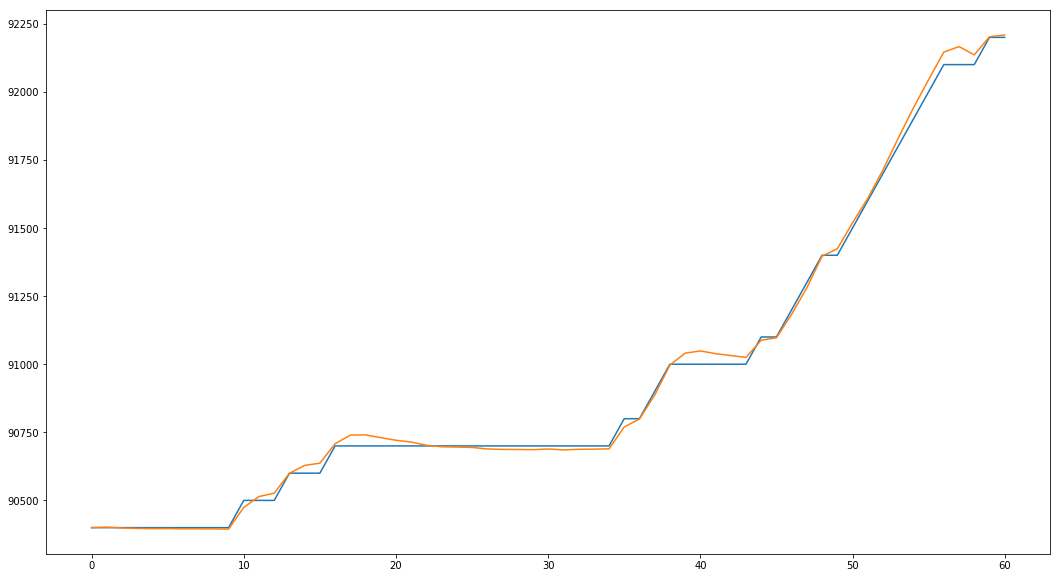

In [105]:
plt.figure(figsize=(18,10))
plt.plot(df_shl_pm['bid'])
plt.plot(df_shl_pm['pred_price'])



# End of shl_sm

In [ ]:

# create global base price

# create predictino results dataframe: shl_pm
df_shl_pm = pd.DataFrame()


In [ ]:
# append into predictino results dataframe: shl_pm




In [ ]:
df_shl_pm = pd.DataFrame()

In [ ]:

d = {
     'ccyy-mm' : df_history_ts_process['ccyy-mm'][1830]
    ,'time' : df_history_ts_process['time'][1830]
    ,'bid' : 1.8
}


In [ ]:
df_shl_pm = df_shl_pm.append(d, ignore_index=True)

In [ ]:
df_shl_pm

# Start of prediction module: shl_pm

In [ ]:
def 

In [ ]:

# create global base price

# create predictino results dataframe: shl_pm
df_shl_pm = pd.DataFrame()


In [ ]:
# append into predictino results dataframe: shl_pm




In [ ]:
df_shl_pm = pd.DataFrame()

In [ ]:

d = {
     'ccyy-mm' : df_history_ts_process['ccyy-mm'][1830]
    ,'time' : df_history_ts_process['time'][1830]
    ,'bid' : 1.8
}


In [ ]:
df_shl_pm = df_shl_pm.append(d, ignore_index=True)

In [ ]:
df_shl_pm

# End of prediction module: shl_pm

# [1] Import useful reference packages

In [ ]:
# from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import operator
from scipy import interp
from itertools import cycle
from sklearn import svm
from sklearn.utils.validation import check_random_state
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from statsmodels.graphics.mosaicplot import mosaic
print(__doc__)

# [2] Data pre-porcessing
Explore and visualize data

### Parameters

In [ ]:
parm_calculate_base_price_second = 15 # Use the current month's bid-price as base-price at this seconds. Later to derive increment-price
parm_calculate_target_second = 7 # How many seconds in future to predict: target variable
parm_calculate_prev_bp = 15 # Number of previous price/increment to include, i.e. previous 2sec, 3sec, 4sec, 5sec ... 15sec
parm_calculate_mv = 15 # Number of  previous price/increment Moving Average to calculate, i.e. previous 2sec, 3sec, 4sec, 5sec ... 15sec
parm_calculate_prev_month = 3 # Number of previous month to include (need to remove earliest x month from training data)
print('parm_calculate_base_price_second : %3d seconds' % parm_calculate_base_price_second)
print('parm_calculate_target_second     : %3d seconds' % parm_calculate_target_second)
print('parm_calculate_prev_bp           : %3d seconds' % parm_calculate_prev_bp)
print('parm_calculate_mv                : %3d seconds' % parm_calculate_mv)
print('parm_calculate_prev_month        : %3d months' % parm_calculate_prev_month)

print('' )
parm_ts_cycle = 61 # seconds/records per month
print('parm_ts_cycle                    : %3d seconds' % parm_ts_cycle)
parm_ts_month = int(len(df_history_ts_process) / parm_ts_cycle)
print('parm_ts_month                    : %3d months' %  parm_ts_month)

parm_record_cut_row_head = max(parm_calculate_base_price_second, parm_calculate_prev_bp, parm_calculate_mv)
parm_record_cut_row_tail = parm_calculate_target_second
parm_record_cut_month_head = parm_calculate_prev_month + 1

parm_ts_valid_cycle = parm_ts_cycle - parm_record_cut_row_head - parm_record_cut_row_tail
print('parm_ts_valid_cycle              : %3d seconds' % parm_ts_valid_cycle)
parm_ts_valid_month = parm_ts_month - parm_record_cut_month_head
print('parm_ts_valid_month              : %3d months' % parm_ts_valid_month)

if parm_record_cut_month_head < 10:
    parm_record_cut_ccyy = pd.to_datetime('2015-0'+str(parm_record_cut_month_head))
else:
    parm_record_cut_ccyy = pd.to_datetime('2015-'+str(parm_record_cut_month_head))

print('' )
print('parm_record_cut_ccyy             : %s' % parm_record_cut_ccyy)

print('parm_record_cut_month_head       : %3d months' % parm_record_cut_month_head)
print('parm_record_cut_row_head         : %3d seconds' % parm_record_cut_row_head)
print('parm_record_cut_row_tail         : %3d seconds' % parm_record_cut_row_tail)
print('' )





In [ ]:
df_history_ts_process.head()

### Prepare derived features

### Process: df_history_ts_process

In [ ]:
# date of current month
df_history_ts_process['date-curr'] = df_history_ts_process.apply(lambda row: pd.to_datetime(row['ccyy-mm']), axis=1)

# date of previous month
df_history_ts_process['date-prev'] = df_history_ts_process.apply(lambda row: row['date-curr'] - pd.offsets.MonthBegin(1), axis=1)


# Year
df_history_ts_process['year'] = df_history_ts_process.apply(lambda row: row['ccyy-mm'][0:4], axis=1)

# Month
df_history_ts_process['month'] = df_history_ts_process.apply(lambda row: row['ccyy-mm'][5:7], axis=1)

# Hour
df_history_ts_process['hour'] = df_history_ts_process.apply(lambda row: row['time'][0:2], axis=1)

# Minute
df_history_ts_process['minute'] = df_history_ts_process.apply(lambda row: row['time'][3:5], axis=1)

# Second
df_history_ts_process['second'] = df_history_ts_process.apply(lambda row: row['time'][6:8], axis=1)


# datetime of current month
df_history_ts_process['datetime-curr'] = df_history_ts_process.apply(lambda row: str(row['date-curr']) + ' ' + row['time'], axis=1)

# datetime of previous month
df_history_ts_process['datetime-prev'] = df_history_ts_process.apply(lambda row: str(row['date-prev']) + ' ' + row['time'], axis=1)


In [ ]:
df_history_ts_process.tail()

In [ ]:
# df_history_ts_process
# df_history_ts_process[1768:]

In [ ]:
# new ['base-price']
gap = 1 # only one new feature/column

for gap in range(1, gap+1):
    col_name = 'base-price'+str(parm_calculate_base_price_second)+'sec'
    col_name_base_price = col_name
    col_data = pd.DataFrame(columns=[col_name])
    print('Creating : ', col_name)  

    for month in range(0, parm_ts_month):
        for i in range(0, parm_ts_cycle):
            col_data.loc[month*parm_ts_cycle+i] = df_history_ts_process['bid-price'][month*parm_ts_cycle+parm_calculate_base_price_second]
  
    df_history_ts_process[col_name] = col_data

print('Total records processed : ', len(col_data))  

In [ ]:
# df_history_ts_process
# df_history_ts_process[1768:]

In [ ]:
# new ['increment-price'] = ['bid-price'] - ['base-price']

df_history_ts_process['increment-price'] = df_history_ts_process.apply(lambda row: row['bid-price'] - row[col_name_base_price], axis=1)

In [ ]:
# df_history_ts_process
# df_history_ts_process[1768:]

In [ ]:
plt.figure()
plt.plot(df_history_ts_process['bid-price'])
plt.plot(df_history_ts_process[col_name_base_price])
plt.plot()
plt.figure()
plt.plot(df_history_ts_process['increment-price'])
plt.plot()

### ['increment-price-target']

In [ ]:
# previous N sec ['increment-price-target']

for gap in range(1, 2):
    col_name = 'increment-price-target'
    col_data = pd.DataFrame(columns=[col_name])
    print('Creating : ', col_name)  

    for month in range(0, parm_ts_month):
    #     print('month : ', month)
        for i in range(0, (parm_ts_cycle - parm_calculate_target_second)):
            col_data.loc[month*parm_ts_cycle+i] = df_history_ts_process['increment-price'][month*parm_ts_cycle+i+parm_calculate_target_second]
        for i in range((parm_ts_cycle - parm_calculate_target_second), parm_ts_cycle):
            col_data.loc[month*parm_ts_cycle+i] = 0
  
    df_history_ts_process[col_name] = col_data

print('Total records processed : ', len(col_data))  

In [ ]:
plt.figure()
plt.plot(df_history_ts_process['increment-price'])
plt.plot(df_history_ts_process['increment-price-target'])
plt.plot()

plt.figure()
plt.plot(df_history_ts_process['increment-price'][1768:])
plt.plot(df_history_ts_process['increment-price-target'][1768:])
plt.plot()

In [ ]:
# previous 'parm_calculate_prev_bp' sec ['increment-price']
gap = parm_calculate_prev_bp

for gap in range(1, gap+1):
    col_name = 'increment-price-prev'+str(gap)+'sec'
    col_data = pd.DataFrame(columns=[col_name])
#     col_data_zeros = pd.DataFrame({col_name: np.zeros(gap)})
    print('Creating : ', col_name)  

    for month in range(0, parm_ts_month):
    #     print('month : ', month)
#         col_data.append(col_data_zeros)
        for i in range(0, gap):
            col_data.loc[month*parm_ts_cycle+i] = 0
        for i in range(gap, parm_ts_cycle):
            col_data.loc[month*parm_ts_cycle+i] = df_history_ts_process['increment-price'][month*parm_ts_cycle+i-gap]
  
    df_history_ts_process[col_name] = col_data

print('Total records processed : ', len(col_data))  

In [ ]:
# previous 'parm_calculate_mv' sec Moving Average ['increment-price']

gap = parm_calculate_mv

for gap in range(2, gap+1): # MV starts from 2 seconds, till parm_calculate_mv
    col_name = 'increment-price-mv'+str(gap)+'sec'
    col_data = pd.DataFrame(columns=[col_name])
    print('Creating : ', col_name)  

    for month in range(0, parm_ts_month):
    #     print('month : ', month)
        for i in range(0, gap):
            col_data.loc[month*parm_ts_cycle+i] = 0
        for i in range(gap, parm_ts_cycle):
            col_data.loc[month*parm_ts_cycle+i] = \
            np.mean(df_history_ts_process['increment-price'][month*parm_ts_cycle+i-gap:month*parm_ts_cycle+i])
  
    df_history_ts_process[col_name] = col_data

print('Total records processed : ', len(col_data)) 

In [ ]:
# df_history_ts_process[1768:]

In [ ]:
plt.figure()
plt.plot(df_history_ts_process['increment-price'][1768:])
plt.plot(df_history_ts_process['increment-price-prev3sec'][1768:])
plt.plot(df_history_ts_process['increment-price-prev7sec'][1768:])
plt.plot(df_history_ts_process['increment-price-prev11sec'][1768:])
plt.plot(df_history_ts_process['increment-price-prev15sec'][1768:])
plt.plot()

In [ ]:
plt.figure()
plt.plot(df_history_ts_process['increment-price'][1768:])
plt.plot(df_history_ts_process['increment-price-mv3sec'][1768:])
plt.plot(df_history_ts_process['increment-price-mv7sec'][1768:])
plt.plot(df_history_ts_process['increment-price-mv11sec'][1768:])
plt.plot(df_history_ts_process['increment-price-mv15sec'][1768:])
plt.plot()

### Process: df_history_table_process

In [ ]:
df_history_table_process.tail()

In [ ]:
# date of current month
df_history_table_process['date-curr'] = df_history_table_process.apply(lambda row: pd.to_datetime(row['ccyy-mm']), axis=1)
df_history_table_process['d-avg-low-price'] = df_history_table_process.apply(lambda row: row['deal-price-avg'] - row['deal-price-low'], axis=1)
df_history_table_process['ratio-bid'] = df_history_table_process.apply(lambda row: row['volume-plate'] / row['volume-bidder'], axis=1)

In [ ]:
df_history_table_process.tail()

### Merge dataframe

In [ ]:
df_history_ts_process_tmp2 = df_history_ts_process.copy()

In [ ]:
df_history_ts_process = df_history_ts_process_tmp2.copy()

In [ ]:
# look up current month table data: 'volume-plate', 'ratio-bid'
df_history_ts_process = pd.merge(df_history_ts_process, df_history_table_process[['date-curr', 'volume-plate', 'ratio-bid']], how = 'left', left_on = 'date-curr', right_on = 'date-curr', suffixes=['', '_table'])

In [ ]:
for i in range(0, len(df_history_ts_process.columns)): print(df_history_ts_process.columns[i])

In [ ]:
# look up pevious month table data: 'volume-plate', 'ratio-bid', 'deal-early-second', 'deal-price-avg', 'd-avg-low-price'
df_history_ts_process = pd.merge(df_history_ts_process, df_history_table_process[['date-curr', 'volume-plate', 'ratio-bid', 'deal-early-second', 'deal-price-avg', 'd-avg-low-price']], how = 'left', left_on = 'date-prev', right_on = 'date-curr', suffixes=['', '_m0'])

In [ ]:
df_history_ts_process['d-increment-avg-low-price_m0'] = df_history_ts_process.apply(lambda row: row['increment-price'] - row['d-avg-low-price'], axis=1)


In [ ]:
for i in range(0, len(df_history_ts_process.columns)): print(df_history_ts_process.columns[i])

### Shift to copy previous 'parm_calculate_prev_month' month's data into current row

In [ ]:
# df_history_ts_process = df_history_ts_process_lookup.copy()

In [ ]:
df_history_ts_process_lookup = df_history_ts_process.copy()
df_history_ts_process_lookup.tail()

In [ ]:
# _m1
df_history_ts_process = pd.merge(df_history_ts_process, df_history_ts_process_lookup[[ \
        'datetime-curr', 'datetime-prev', 
        'base-price15sec', 'increment-price', 'increment-price-target',
        'increment-price-prev1sec', 'increment-price-prev2sec',
        'increment-price-prev3sec', 'increment-price-prev4sec',
        'increment-price-prev5sec', 'increment-price-prev6sec',
        'increment-price-prev7sec', 'increment-price-prev8sec',
        'increment-price-prev9sec', 'increment-price-prev10sec',
        'increment-price-prev11sec', 'increment-price-prev12sec',
        'increment-price-prev13sec', 'increment-price-prev14sec',
        'increment-price-prev15sec', 
        'increment-price-mv2sec',
        'increment-price-mv3sec', 'increment-price-mv4sec',
        'increment-price-mv5sec', 'increment-price-mv6sec',
        'increment-price-mv7sec', 'increment-price-mv8sec',
        'increment-price-mv9sec', 'increment-price-mv10sec',
        'increment-price-mv11sec', 'increment-price-mv12sec',
        'increment-price-mv13sec', 'increment-price-mv14sec',
        'increment-price-mv15sec', 
        'volume-plate_m0', 
        'ratio-bid_m0', 
        'deal-early-second',
        'deal-price-avg',
        'd-avg-low-price',
        'd-increment-avg-low-price_m0'
        ]], how = 'left', left_on = 'datetime-prev', right_on = 'datetime-curr', suffixes=['', '_m1'])
df_history_ts_process.tail()

In [ ]:
# _m2
df_history_ts_process = pd.merge(df_history_ts_process, df_history_ts_process_lookup[[ \
        'datetime-curr', 'datetime-prev', 
        'base-price15sec', 'increment-price', 'increment-price-target',
        'increment-price-prev1sec', 'increment-price-prev2sec',
        'increment-price-prev3sec', 'increment-price-prev4sec',
        'increment-price-prev5sec', 'increment-price-prev6sec',
        'increment-price-prev7sec', 'increment-price-prev8sec',
        'increment-price-prev9sec', 'increment-price-prev10sec',
        'increment-price-prev11sec', 'increment-price-prev12sec',
        'increment-price-prev13sec', 'increment-price-prev14sec',
        'increment-price-prev15sec', 
        'increment-price-mv2sec',
        'increment-price-mv3sec', 'increment-price-mv4sec',
        'increment-price-mv5sec', 'increment-price-mv6sec',
        'increment-price-mv7sec', 'increment-price-mv8sec',
        'increment-price-mv9sec', 'increment-price-mv10sec',
        'increment-price-mv11sec', 'increment-price-mv12sec',
        'increment-price-mv13sec', 'increment-price-mv14sec',
        'increment-price-mv15sec', 
        'volume-plate_m0', 
        'ratio-bid_m0', 
        'deal-early-second',
        'deal-price-avg',
        'd-avg-low-price',
        'd-increment-avg-low-price_m0'                                                                                   
        ]], how = 'left', left_on = 'datetime-prev_m1', right_on = 'datetime-curr', suffixes=['', '_m2'])
df_history_ts_process.tail()

In [ ]:
# _m3
df_history_ts_process = pd.merge(df_history_ts_process, df_history_ts_process_lookup[[ \
        'datetime-curr', 'datetime-prev', 
        'base-price15sec', 'increment-price', 'increment-price-target',
        'increment-price-prev1sec', 'increment-price-prev2sec',
        'increment-price-prev3sec', 'increment-price-prev4sec',
        'increment-price-prev5sec', 'increment-price-prev6sec',
        'increment-price-prev7sec', 'increment-price-prev8sec',
        'increment-price-prev9sec', 'increment-price-prev10sec',
        'increment-price-prev11sec', 'increment-price-prev12sec',
        'increment-price-prev13sec', 'increment-price-prev14sec',
        'increment-price-prev15sec', 
        'increment-price-mv2sec',
        'increment-price-mv3sec', 'increment-price-mv4sec',
        'increment-price-mv5sec', 'increment-price-mv6sec',
        'increment-price-mv7sec', 'increment-price-mv8sec',
        'increment-price-mv9sec', 'increment-price-mv10sec',
        'increment-price-mv11sec', 'increment-price-mv12sec',
        'increment-price-mv13sec', 'increment-price-mv14sec',
        'increment-price-mv15sec', 
        'volume-plate_m0', 
        'ratio-bid_m0', 
        'deal-early-second',
        'deal-price-avg',
        'd-avg-low-price',
        'd-increment-avg-low-price_m0'                                                                                  
        ]], how = 'left', left_on = 'datetime-prev_m2', right_on = 'datetime-curr', suffixes=['', '_m3'])
df_history_ts_process.tail()

In [ ]:
plt.figure()
plt.plot(df_history_ts_process['increment-price-mv10sec'][1768:])
plt.plot(df_history_ts_process['increment-price-mv10sec_m1'][1768:])
plt.plot(df_history_ts_process['increment-price-mv10sec_m2'][1768:])
plt.plot(df_history_ts_process['increment-price-mv10sec_m3'][1768:])
plt.figure()
plt.plot(df_history_ts_process['increment-price-prev10sec'][1768:])
plt.plot(df_history_ts_process['increment-price-prev10sec_m1'][1768:])
plt.plot(df_history_ts_process['increment-price-prev10sec_m2'][1768:])
plt.plot(df_history_ts_process['increment-price-prev10sec_m3'][1768:])
plt.figure()
plt.plot(df_history_ts_process['increment-price'][1768:])
plt.plot(df_history_ts_process['increment-price_m1'][1768:])
plt.plot(df_history_ts_process['increment-price_m2'][1768:])
plt.plot(df_history_ts_process['increment-price_m3'][1768:])
plt.figure()
plt.plot(df_history_ts_process['increment-price-target'][1768:])
plt.plot(df_history_ts_process['increment-price-target_m1'][1768:])
plt.plot(df_history_ts_process['increment-price-target_m2'][1768:])
plt.plot(df_history_ts_process['increment-price-target_m3'][1768:])

plt.plot()

### Housekeeping to remove some invald data during pre-processing

In [ ]:
for i in range(0, len(df_history_ts_process.columns)): print(df_history_ts_process.columns[i])

In [ ]:
# housekeeping: delete some columns
# df_history_ts_process.drop('date-curr_y', axis=1, inplace=True)

In [ ]:
parm_record_cut_ccyy

In [ ]:
# remove first 'parm_record_cut_ccyy' months from dataset
df_history_ts_process = df_history_ts_process[df_history_ts_process['date-curr'] > parm_record_cut_ccyy]

In [ ]:
# total 61 seconds/rows per month:
# remove first 'parm_record_cut_row_head' reconds
# remove last 'parm_record_cut_row_tail' reconds
df_history_ts_process = df_history_ts_process[df_history_ts_process['second'] >= str(parm_record_cut_row_head) ]
df_history_ts_process = df_history_ts_process[df_history_ts_process['second'] <= str(60 - parm_record_cut_row_tail) ]
# df_history_ts_process = df_history_ts_process[df_history_ts_process['second'] > parm_record_cut_row_head ]

In [ ]:
# Reset index after housekeeping
df_history_ts_process = df_history_ts_process.reset_index(drop=True)

In [ ]:
df_history_ts_process.head()

In [ ]:
df_history_ts_process.tail()

In [ ]:
plt.figure()
plt.plot(df_history_ts_process['increment-price'][974:])
plt.plot(df_history_ts_process['increment-price-mv3sec'][974:])
plt.plot(df_history_ts_process['increment-price-mv7sec'][974:])
plt.plot(df_history_ts_process['increment-price-mv11sec'][974:])
plt.plot(df_history_ts_process['increment-price-mv15sec'][974:])
plt.figure()
plt.plot(df_history_ts_process['increment-price-mv15sec'][974:])
plt.plot(df_history_ts_process['increment-price-mv15sec_m1'][974:])
plt.plot(df_history_ts_process['increment-price-mv15sec_m2'][974:])
plt.plot(df_history_ts_process['increment-price-mv15sec_m3'][974:])
plt.plot()

# [3] Modeling Part 2: Python scikit-learn

### Models to use:

* GradientBoostingClassifier
* RandomForestClassifier
* AdaBoostClassifier
* ExtraTreesClassifier
* BaggingClassifier
* LogisticRegression
* SVM kernal RBF
* SVM kernal Linear
* KNeighborsClassifier


### Import pre-processed data

In [ ]:
# plt.plot(df_history_ts_process['d-avg-low-price'])
# plt.figure()
# plt.figure()
# plt.plot(df_history_ts_process['d-avg-low-price_m1'])
# plt.figure()
# plt.plot(df_history_ts_process['d-avg-low-price_m2'])
# plt.figure()
# plt.plot(df_history_ts_process['d-avg-low-price_m3'])


In [ ]:
for i in range(0, len(df_history_ts_process.columns)): print(df_history_ts_process.columns[i])

In [ ]:
X = df_history_ts_process[[
#          ,'ccyy-mm'
#         ,'time'
#         ,'bid-price'
#         ,'date-curr'
#         ,'date-prev'
#         ,'year'
         'month'
#         ,'hour'
#         ,'minute'
        ,'second'
#         ,'datetime-curr'
#         ,'datetime-prev'
        ,'base-price15sec'
        ,'increment-price'
#         ,'increment-price-target'   # <<<<<<< This is target 
        ,'increment-price-prev1sec'
        ,'increment-price-prev2sec'
        ,'increment-price-prev3sec'
        ,'increment-price-prev4sec'
        ,'increment-price-prev5sec'
        ,'increment-price-prev6sec'
        ,'increment-price-prev7sec'
        ,'increment-price-prev8sec'
        ,'increment-price-prev9sec'
        ,'increment-price-prev10sec'
        ,'increment-price-prev11sec'
        ,'increment-price-prev12sec'
        ,'increment-price-prev13sec'
        ,'increment-price-prev14sec'
        ,'increment-price-prev15sec'
        ,'increment-price-mv2sec'
        ,'increment-price-mv3sec'
        ,'increment-price-mv4sec'
        ,'increment-price-mv5sec'
        ,'increment-price-mv6sec'
        ,'increment-price-mv7sec'
        ,'increment-price-mv8sec'
        ,'increment-price-mv9sec'
        ,'increment-price-mv10sec'
        ,'increment-price-mv11sec'
        ,'increment-price-mv12sec'
        ,'increment-price-mv13sec'
        ,'increment-price-mv14sec'
        ,'increment-price-mv15sec'
        ,'volume-plate'
        ,'ratio-bid'
#         ,'date-curr_m0'
        ,'volume-plate_m0'
        ,'ratio-bid_m0'
        ,'deal-early-second'
        ,'deal-price-avg'
        ,'d-avg-low-price'
        ,'d-increment-avg-low-price_m0'
    
#         ,'datetime-curr_m1'
#         ,'datetime-prev_m1'
        ,'base-price15sec_m1'
        ,'increment-price_m1'
        ,'increment-price-target_m1'
        ,'increment-price-prev1sec_m1'
        ,'increment-price-prev2sec_m1'
        ,'increment-price-prev3sec_m1'
        ,'increment-price-prev4sec_m1'
        ,'increment-price-prev5sec_m1'
        ,'increment-price-prev6sec_m1'
        ,'increment-price-prev7sec_m1'
        ,'increment-price-prev8sec_m1'
        ,'increment-price-prev9sec_m1'
        ,'increment-price-prev10sec_m1'
        ,'increment-price-prev11sec_m1'
        ,'increment-price-prev12sec_m1'
        ,'increment-price-prev13sec_m1'
        ,'increment-price-prev14sec_m1'
        ,'increment-price-prev15sec_m1'
        ,'increment-price-mv2sec_m1'
        ,'increment-price-mv3sec_m1'
        ,'increment-price-mv4sec_m1'
        ,'increment-price-mv5sec_m1'
        ,'increment-price-mv6sec_m1'
        ,'increment-price-mv7sec_m1'
        ,'increment-price-mv8sec_m1'
        ,'increment-price-mv9sec_m1'
        ,'increment-price-mv10sec_m1'
        ,'increment-price-mv11sec_m1'
        ,'increment-price-mv12sec_m1'
        ,'increment-price-mv13sec_m1'
        ,'increment-price-mv14sec_m1'
        ,'increment-price-mv15sec_m1'
        ,'volume-plate_m0_m1'
        ,'ratio-bid_m0_m1'
        ,'deal-early-second_m1'
        ,'deal-price-avg_m1'
        ,'d-avg-low-price_m1'
        ,'d-increment-avg-low-price_m0_m1'

#         ,'datetime-curr_m2'
#         ,'datetime-prev_m2'
        ,'base-price15sec_m2'
        ,'increment-price_m2'
        ,'increment-price-target_m2'
        ,'increment-price-prev1sec_m2'
        ,'increment-price-prev2sec_m2'
        ,'increment-price-prev3sec_m2'
        ,'increment-price-prev4sec_m2'
        ,'increment-price-prev5sec_m2'
        ,'increment-price-prev6sec_m2'
        ,'increment-price-prev7sec_m2'
        ,'increment-price-prev8sec_m2'
        ,'increment-price-prev9sec_m2'
        ,'increment-price-prev10sec_m2'
        ,'increment-price-prev11sec_m2'
        ,'increment-price-prev12sec_m2'
        ,'increment-price-prev13sec_m2'
        ,'increment-price-prev14sec_m2'
        ,'increment-price-prev15sec_m2'
        ,'increment-price-mv2sec_m2'
        ,'increment-price-mv3sec_m2'
        ,'increment-price-mv4sec_m2'
        ,'increment-price-mv5sec_m2'
        ,'increment-price-mv6sec_m2'
        ,'increment-price-mv7sec_m2'
        ,'increment-price-mv8sec_m2'
        ,'increment-price-mv9sec_m2'
        ,'increment-price-mv10sec_m2'
        ,'increment-price-mv11sec_m2'
        ,'increment-price-mv12sec_m2'
        ,'increment-price-mv13sec_m2'
        ,'increment-price-mv14sec_m2'
        ,'increment-price-mv15sec_m2'
        ,'volume-plate_m0_m2'
        ,'ratio-bid_m0_m2'
        ,'deal-early-second_m2'
        ,'deal-price-avg_m2'
        ,'d-avg-low-price_m2'
        ,'d-increment-avg-low-price_m0_m2'

#         ,'datetime-curr_m3'
#         ,'datetime-prev_m3'
        ,'base-price15sec_m3'
        ,'increment-price_m3'
        ,'increment-price-target_m3'
        ,'increment-price-prev1sec_m3'
        ,'increment-price-prev2sec_m3'
        ,'increment-price-prev3sec_m3'
        ,'increment-price-prev4sec_m3'
        ,'increment-price-prev5sec_m3'
        ,'increment-price-prev6sec_m3'
        ,'increment-price-prev7sec_m3'
        ,'increment-price-prev8sec_m3'
        ,'increment-price-prev9sec_m3'
        ,'increment-price-prev10sec_m3'
        ,'increment-price-prev11sec_m3'
        ,'increment-price-prev12sec_m3'
        ,'increment-price-prev13sec_m3'
        ,'increment-price-prev14sec_m3'
        ,'increment-price-prev15sec_m3'
        ,'increment-price-mv2sec_m3'
        ,'increment-price-mv3sec_m3'
        ,'increment-price-mv4sec_m3'
        ,'increment-price-mv5sec_m3'
        ,'increment-price-mv6sec_m3'
        ,'increment-price-mv7sec_m3'
        ,'increment-price-mv8sec_m3'
        ,'increment-price-mv9sec_m3'
        ,'increment-price-mv10sec_m3'
        ,'increment-price-mv11sec_m3'
        ,'increment-price-mv12sec_m3'
        ,'increment-price-mv13sec_m3'
        ,'increment-price-mv14sec_m3'
        ,'increment-price-mv15sec_m3'
        ,'volume-plate_m0_m3'
        ,'ratio-bid_m0_m3'
        ,'deal-early-second_m3'
        ,'deal-price-avg_m3'
        ,'d-avg-low-price_m3'
        ,'d-increment-avg-low-price_m0_m3'
        ]]

X_col = X.columns # get the column list

# X = StandardScaler().fit_transform(X.as_matrix())
X = X.as_matrix()

# y = StandardScaler().fit_transform(df_wnv_raw[['increment-price-target']].as_matrix()).reshape(len(df_wnv_raw),)
y = df_history_ts_process[['increment-price-target']].as_matrix().reshape(len(df_history_ts_process),)


In [ ]:
X_col

In [ ]:
plt.figure()
plt.plot(X)
plt.figure()
plt.plot(y)


# [4] Evaluation
### K-fold Cross-Validation

In [ ]:
rng = check_random_state(0)

In [ ]:
# GB
classifier_GB = GradientBoostingRegressor(n_estimators=1500, # score: 0.94608 (AUC 0.81419), learning_rate=0.001, max_features=8 <<< Best
#                                    loss='deviance',
#                                    subsample=1,
#                                    max_depth=5,
#                                    min_samples_split=20,
                                   learning_rate=0.002,
#                                    max_features=10,
                                   random_state=rng)

In [ ]:
# AB
classifier_AB = AdaBoostRegressor(n_estimators=1500, # score: 0.93948 (AUC 0.88339), learning_rate=0.004 <<< Best
                                   learning_rate=0.002,
                                   random_state=rng)

In [ ]:
# RF
classifier_RF = RandomForestRegressor(n_estimators=1500, # score: 0.94207 (AUC 0.81870), max_depth=3, min_samples_split=20, <<< Best
#                                     max_features=10,
#                                     max_depth=3,
#                                     min_samples_split=20,
                                    random_state=rng)

In [ ]:
# ET
classifier_ET = ExtraTreesRegressor(n_estimators=1000, # score: 0.94655 (AUC 0.84364), max_depth=3, min_samples_split=20, max_features=10 <<< Best
#                                     max_depth=3,
#                                     min_samples_split=20,
#                                     max_features=10,
                                    random_state=rng)

In [ ]:
# BG
classifier_BG = BaggingRegressor(n_estimators=500, # score: 0.70725 (AUC 0.63729) <<< Best
#                                     max_features=10,
                                    random_state=rng)

### LR

In [ ]:
classifier_LR = LinearRegression() # score: 0.90199 (AUC 0.80569)

### SVM Linear

In [ ]:
# classifier_SVCL = svm.SVC(kernel='linear', probability=True, random_state=rng) # score: 0.89976 (AUC 0.70524)
classifier_SVRL = svm.SVR(kernel='linear') # score: 0.89976 (AUC 0.70524)

### SVM

In [ ]:
classifier_SVRR = svm.SVR(kernel='rbf') # score: 0.80188 (AUC 0.50050)
# classifier_SVRR = svm.SVR(kernel='poly') # score: 0.80188 (AUC 0.50050)

### KNN

In [ ]:
classifier_KNN = KNeighborsRegressor(n_neighbors=2) # score: 0.94018 (AUC 0.72792)
cv = cross_val_score(classifier_KNN,
                            X,
                            y,
                            cv=StratifiedKFold(parm_ts_valid_month))
print('KNN CV score: {0:.5f}'.format(cv.mean()))

### Select Model

In [ ]:
# classifier = classifier_GB     # 219.099617786
# classifier = classifier_AB     # 230.101439444
classifier = classifier_RF     # 197.955555556
# classifier = classifier_ET     # 
# classifier = classifier_BG     # 
# classifier = classifier_LR     # 
# classifier = classifier_SVRL   # 
# classifier = classifier_SVRR   # 

### Split Data

In [ ]:
n_splits = parm_ts_valid_cycle
print('cycle seconds : %d' % n_splits)
# n_splits=54 # 19 seconds/records for each bidding month
# n_splits=19 # 19 seconds/records for each bidding month
n_fold = parm_ts_valid_month
print('cycle month   : %d' % n_fold)


# X_train_1 = X[0:(len(X)-batch*n_splits)]
# y_train_1 = y[0:(len(X)-batch*n_splits)]

# X_test_1 = X[(len(X)-batch*n_splits):((len(X)-batch*n_splits)+n_splits)]
# y_test_1 = y[(len(X)-batch*n_splits):((len(X)-batch*n_splits)+n_splits)]


### Cross-Validation

In [ ]:
n_fold=7

In [ ]:
y_pred = {}
y_test = {}

y_pred_org = {}
y_test_org = {}

i = 0
for batch in range(1, n_fold):
    X_train_1 = X[0:(len(X)-batch*n_splits)]
    y_train_1 = y[0:(len(X)-batch*n_splits)]
    X_test_1  = X[(len(X)-batch*n_splits):((len(X)-batch*n_splits)+n_splits)]
    y_test_1  = y[(len(X)-batch*n_splits):((len(X)-batch*n_splits)+n_splits)]
    print(len(X_train_1))
    
    # ReScale
    ScalerX = StandardScaler()
    ScalerX.fit(X_train_1)
    X_train_1 = ScalerX.transform(X_train_1)
    X_test_1  = ScalerX.transform(X_test_1)
    
    ScalerY = StandardScaler()
    ScalerY.fit(y_train_1.reshape(-1, 1))
    y_train_1 = ScalerY.transform(y_train_1.reshape(-1, 1))
    y_test_1  = ScalerY.transform(y_test_1.reshape(-1, 1))
    
    y_pred[i] = classifier.fit(X_train_1, y_train_1).predict(X_test_1)
    y_test[i] = y_test_1  

    y_pred_org[i] = ScalerY.inverse_transform(y_pred[i])
    y_test_org[i] = ScalerY.inverse_transform(y_test[i])
    
    plt.figure()
    plt.plot(y_train_1)
    plt.plot()
    plt.figure()
    plt.plot(y_test[i])
    plt.plot(y_pred[i])
    plt.plot()
    i += 1

### no inverse-scale

In [ ]:
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test[i] - y_pred[i]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
# 49~51 second predicts 56~58 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test[i][34:36] - y_pred[i][34:36]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

### inverse-scale

In [ ]:
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i] - y_pred_org[i]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
# 49~51 second predicts 56~58 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][34:36] - y_pred_org[i][34:36]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
# 48 second predicts 56 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][33:34] - y_pred_org[i][33:34]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
# 49 second predicts 56 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][34:35] - y_pred_org[i][34:35]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
# 50 second predicts 57 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][35:36] - y_pred_org[i][35:36]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
# 51 second predicts 58 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][36:37] - y_pred_org[i][36:37]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
# 52 second predicts 59 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][37:38] - y_pred_org[i][37:38]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
# 53 second predicts 60 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][38:39] - y_pred_org[i][38:39]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

In [ ]:
plt.plot(y_test_org[0])
plt.plot(y_pred_org[0])

In [ ]:
plt.plot(k)

In [ ]:
# plt.plot(df_history_ts_process['increment-price-target'][819:])
plt.plot(df_history_ts_process['increment-price'][819:])
plt.plot(df_history_ts_process['d-increment-avg-low-price_m0'][819:])
plt.plot(df_history_ts_process['increment-price'][819:] - df_history_ts_process['d-increment-avg-low-price_m0'][819:])
plt.figure()
plt.plot(df_history_ts_process['d-increment-avg-low-price_m0'][819:])
plt.plot(df_history_ts_process['d-increment-avg-low-price_m0_m1'][819:])
plt.plot(df_history_ts_process['d-increment-avg-low-price_m0_m2'][819:])
plt.plot(df_history_ts_process['d-increment-avg-low-price_m0_m3'][819:])


### Model Feature Importances:

In [ ]:
def util_feature_importances(classifier):
    print(classifier)
    dict_importance ={}
    for i in range(len(X_col)):
        dict_importance[X_col[i]] = classifier.feature_importances_[i]
        dict_importance_sort = sorted(dict_importance.items(), key=operator.itemgetter(1), reverse=True)
    return dict_importance_sort

In [ ]:
util_feature_importances(classifier_GB)

In [ ]:
util_feature_importances(classifier_RF)

In [ ]:
util_feature_importances(classifier_AB)

In [ ]:
util_feature_importances(classifier_ET)

---

### The End